In [1]:
import pandas as pd
df = pd.read_csv("../Python/Dataset/EEG_dataset/Joan2.txt")
df.columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l','m']
df.to_csv('Joan.txt')

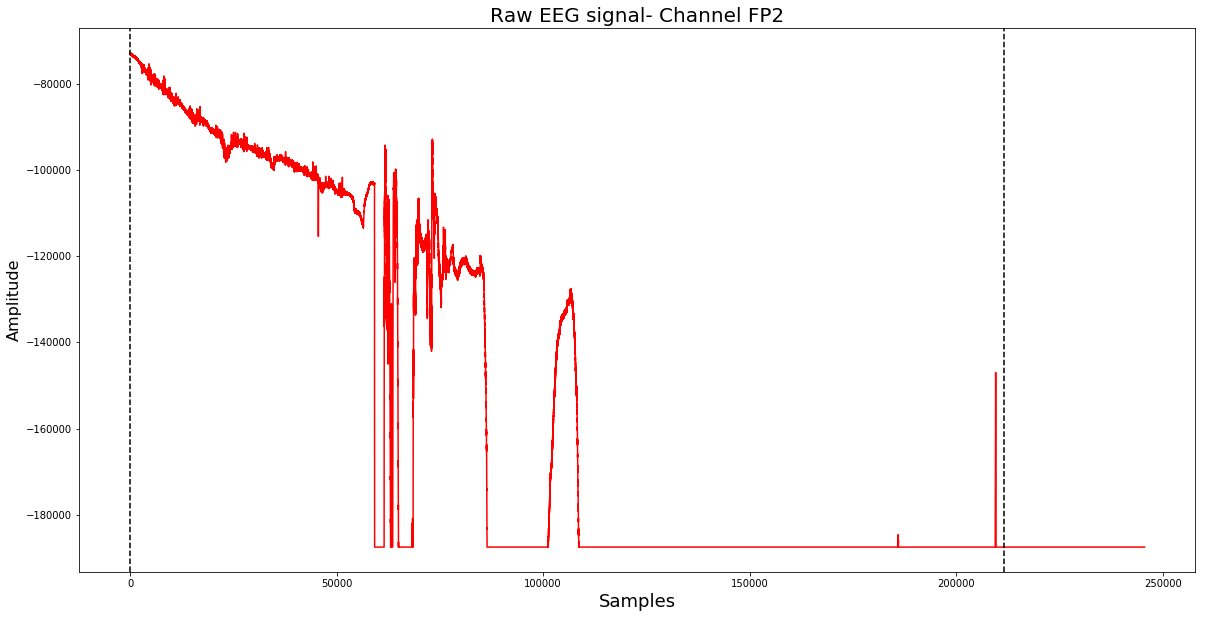

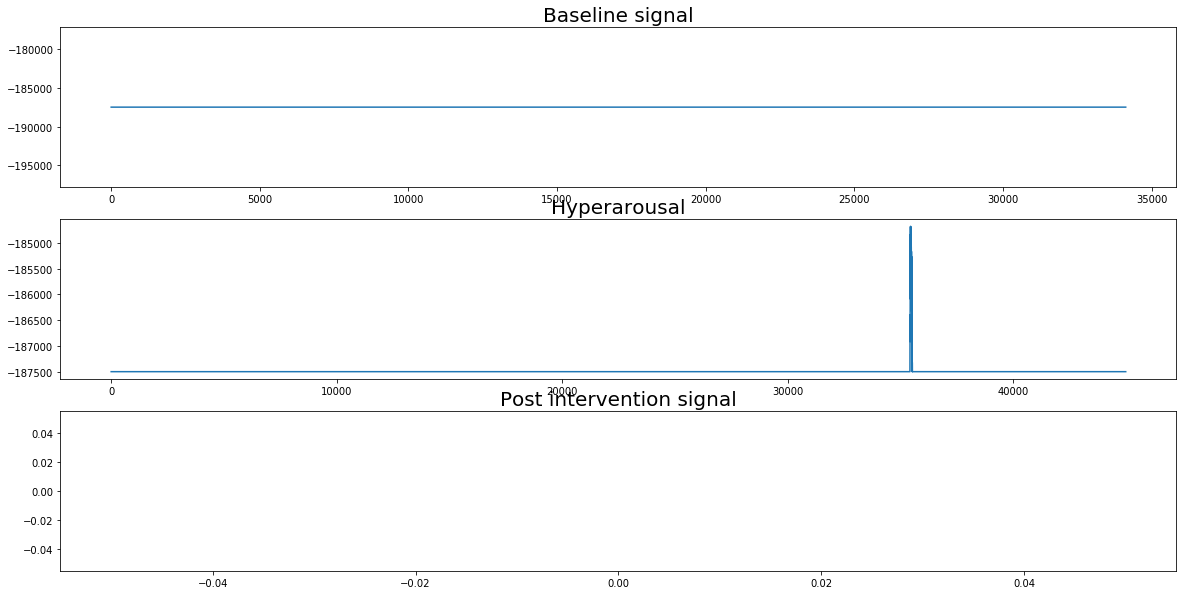

In [75]:
#select channels and remove set up noise
import pandas as pd
df = pd.read_csv("../Python/Dataset/EEG_dataset/JoanM.txt", usecols=['c'])
saved_column = df.c
#print(saved_column)
#len(saved_column)
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(saved_column,'r-')
xposition = [0.0, 211500] #324000, 445000, 490000]
for xc in xposition:
    plt.axvline(x=xc, color='k', linestyle='--')
plt.title('Raw EEG signal- Channel FP2', fontsize=20)
plt.xlabel('Samples', fontsize=18)
plt.ylabel('Amplitude', fontsize=16)
saved_column1 = saved_column[211500:256500]
saved_column2 = saved_column[150500:195500]
saved_column3 = saved_column[451500:496500]
#len(saved_column1)
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(range(len(saved_column1)),saved_column1)
plt.title('Baseline signal' ,fontsize=20)
plt.subplot(312)
plt.plot(range(len(saved_column2)),saved_column2)
plt.title('Hyperarousal',fontsize=20)
plt.subplot(313)
plt.plot(range(len(saved_column3)),saved_column3)
plt.title('Post intervention signal',fontsize=20)

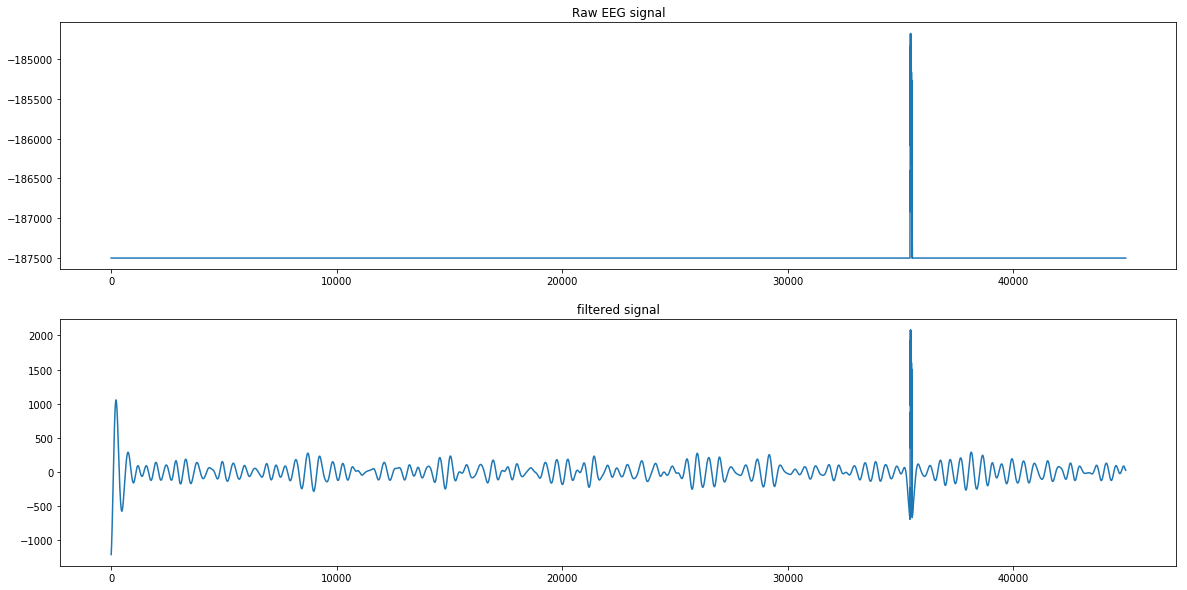

In [76]:
# selected range bring it into normal amplitude range by removing dc offset
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt


def butter_highpass(cutoff, fs, order=7):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=7):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

fps = 250



filtered_sine = butter_highpass_filter(saved_column2,0.5,fps)

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(range(len(saved_column2)),saved_column2)
plt.title('Raw EEG signal')
plt.subplot(212)
plt.plot(range(len(filtered_sine)),filtered_sine)
plt.title('filtered signal')
plt.show()

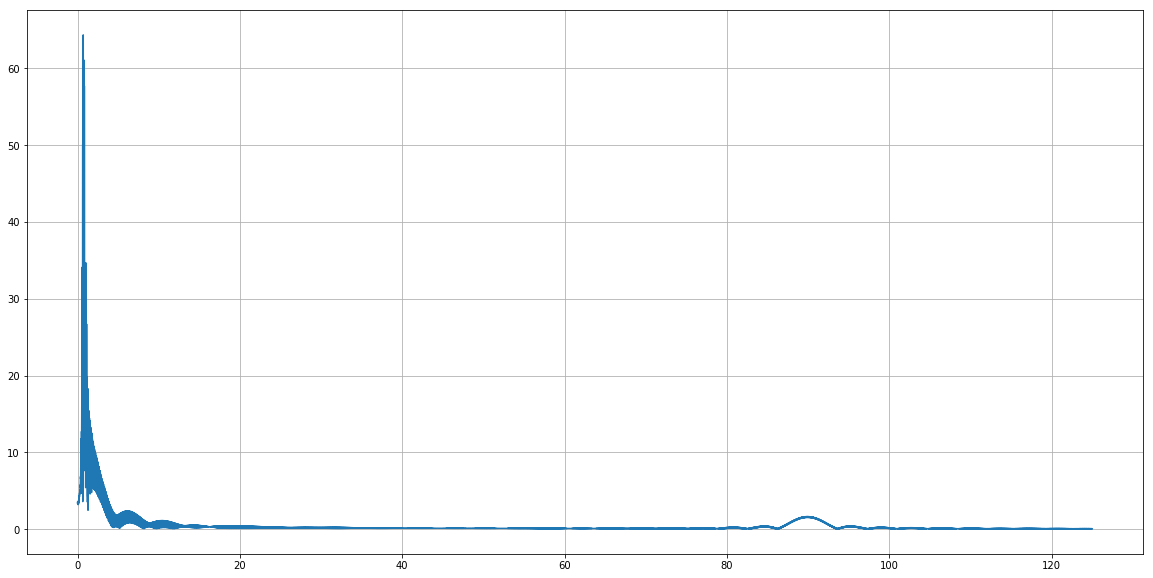

In [77]:
#check fft directly- include noise and 60hz noise
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = 30000
# sample spacing
T = 1.0 / 250.0
yf = scipy.fftpack.fft(filtered_sine)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

plt.figure(figsize=(20,10))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.grid(True)
plt.show()

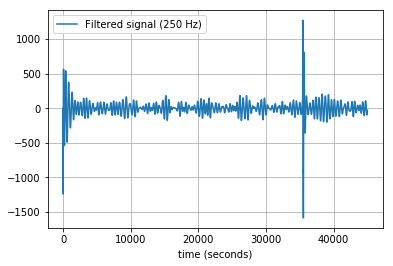

In [78]:
#band pass filter between 0.5 and 40 hz
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 250.0
    lowcut = 0.5
    highcut = 40.0

    
    # Filter a noisy signal.
    #T = 0.05
    #nsamples = T * fs
    #t = np.linspace(0, T, nsamples, endpoint=False)
    a = 0.02
    f0 = 250.0
    x = filtered_sine

    plt.figure(2)
    plt.clf()
    #plt.plot(x, label='Noisy signal')

    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    plt.plot(y, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')

    plt.show()

In [79]:
#notch filter apllied at 60hz
def Implement_Notch_Filter(time, band, freq, ripple, order, filter_type, data):
    from scipy.signal import iirfilter
    fs   = 1/time
    nyq  = fs/2.0
    low  = freq - band/2.0
    high = freq + band/2.0
    low  = low/nyq
    high = high/nyq
    b, a = iirfilter(order, [low, high], rp=ripple, btype='bandstop',
                     analog=False, ftype=filter_type)
    filtered_data = lfilter(b, a, data)
    return filtered_data

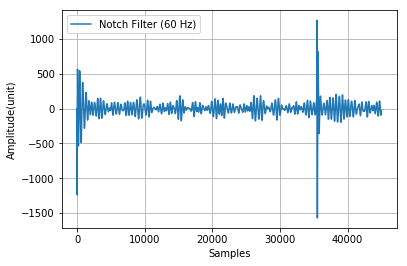

In [80]:
array = Implement_Notch_Filter(0.004, 1, 60, 1, 2, 'butter', y)
plt.plot(array, label='Notch Filter (60 Hz)')
plt.xlabel('Samples')
plt.hlines([-a, a], 0, T, linestyles='--')
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')
plt.ylabel('Amplitude(unit)')


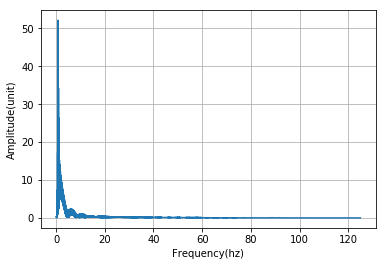

In [81]:
#check fft again
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = 30000
# sample spacing
T = 1.0 / 250.0
yf = scipy.fftpack.fft(array)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
ax.grid(True)
ax.set_xlabel('Frequency(hz)')
ax.set_ylabel('Amplitude(unit)')
plt.show()

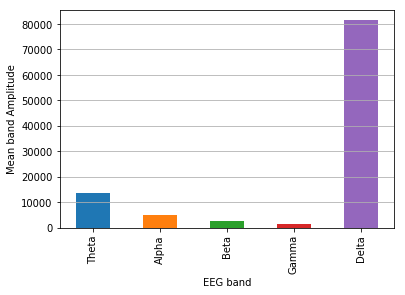

In [82]:
#find band amplitude
import numpy as np

fs = 250                                # Sampling rate (512 Hz)
data = array  # 2 sec of data b/w 0.0-100.0

# Get real amplitudes of FFT (only in postive frequencies)
fft_vals = np.absolute(np.fft.rfft(data))

# Get frequencies for amplitudes in Hz
fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

# Define EEG bands
eeg_bands = {'Delta': (0, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 40)}

# Take the mean of the fft amplitude for each EEG band
eeg_band_fft = dict()
for band in eeg_bands:  
    freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                       (fft_freq <= eeg_bands[band][1]))[0]
    eeg_band_fft[band] = np.mean(fft_vals[freq_ix])

# Plot the data (using pandas here cause it's easy)
import pandas as pd
df = pd.DataFrame(columns=['band', 'val'])
df['band'] = eeg_bands.keys()
df['val'] = [eeg_band_fft[band] for band in eeg_bands]
ax = df.plot.bar(x='band', y='val', legend=False)
ax.set_xlabel("EEG band")
ax.set_ylabel("Mean band Amplitude")
ax.yaxis.grid(True)

In [83]:

a1=eeg_band_fft['Alpha']
a2=eeg_band_fft['Beta']
a3=eeg_band_fft['Delta']
a4=eeg_band_fft['Gamma']
a5=eeg_band_fft['Theta']
'''
b1=eeg_band_fft['Alpha']
b2=eeg_band_fft['Beta']
b3=eeg_band_fft['Delta']
b4=eeg_band_fft['Gamma']
b5=eeg_band_fft['Theta']

c1=eeg_band_fft['Alpha']
c2=eeg_band_fft['Beta']
c3=eeg_band_fft['Delta']
c4=eeg_band_fft['Gamma']
c5=eeg_band_fft['Theta']
'''

"\nb1=eeg_band_fft['Alpha']\nb2=eeg_band_fft['Beta']\nb3=eeg_band_fft['Delta']\nb4=eeg_band_fft['Gamma']\nb5=eeg_band_fft['Theta']\n\nc1=eeg_band_fft['Alpha']\nc2=eeg_band_fft['Beta']\nc3=eeg_band_fft['Delta']\nc4=eeg_band_fft['Gamma']\nc5=eeg_band_fft['Theta']\n"

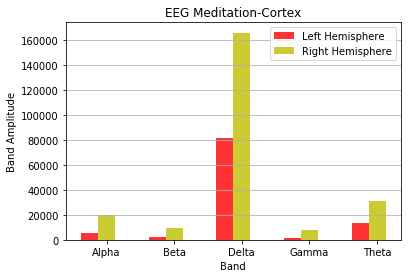

In [84]:
#multiple bar plot for comparison
import numpy as np
import matplotlib.pyplot as plt
 
# data to plot
n_groups = 5
means_frank = (a1, a2, a3, a4, a5)
means_guido = (b1, b2, b3, b4, b5)
means_porthos = (0, 0, 0, 0, 0)
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, means_frank, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Left Hemisphere')

rects2 = plt.bar(index + bar_width, means_guido, bar_width,
                 alpha=opacity,
                 color='y',
                 label='Right Hemisphere')

#rects3 = plt.bar(index + 2*bar_width, means_porthos, bar_width,
                 #alpha=opacity,
                 #color='b',
                 #label='Post Meditation')

plt.xlabel('Band')
plt.ylabel('Band Amplitude')
plt.title('EEG Meditation-Cortex')
plt.xticks(index + bar_width, ('Alpha', 'Beta', 'Delta', 'Gamma', 'Theta'))
plt.legend()
ax.yaxis.grid(True)
 
#plt.tight_layout()
#plt.show()